# Outline:


* Membership Inference Attacks (MIA) on Machine Learning Models
  * Definition
  * Types of Membership Inference Attacks
  * Membership Inference Attack Methods
  * Defences Against Membership Inference Attacks

*   Membership Inference Attack in Tensorflow Privacy

*   Defending the Membership Inference Attacks Using Differential Privacy in Tensorflow Privacy

* References




# Membership Inference Attacks (MIA) on Machine Learning Models 
## Definition

* MIA on machine learning models aim to identify whether a data sample
was used to train the target machine learning model or not

  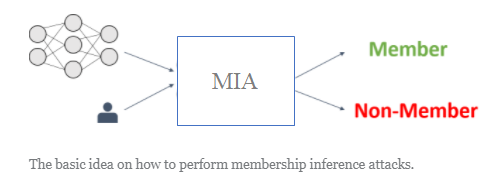



* MIA can raise severe privacy risks to
individuals. For example, identifying that a certain patient‚Äôs clinical record was used to train a model associated with a disease reveals that the patient has this disease

## Types of Membership Inference Attacks

### MIA against ML models mainly focus on deep learning models because they are more prone to suffer from overfitting issues, which can be exploited by membership inference attacks

### Based on what information is available to the adversary, i.e., adversarial knowledge, membership inference attacks can be divided as follows:


*  Black-box inference attacks
*  White-box inference attacks


### Adversarial knowledge categorization
* Data knowledge: Knowledge of the data distribution of ùê∑ùë°ùëüùëéùëñùëõ
* Training knowledge:  Optimization algorithm, number of training steps, settings of the optimization algorithm,
etc.
* Model knowledge:
  *  Model architecture: Type of neural network, the number of layers, the type of activation function, etc. 
  *  Model parameters
* Output knowledge:
  * Full output knowledge 
  * Partial output knowledge
  * Label-only knowledge

###Generally, the adversary is assumed to have data knowledge, training knowledge, and output knowledge of the target model. Based on whether the adversary can have access to the model knowledge of model parameters, MIA can be categorized into **black-box** and **white-box** inference attacks. In the following Table, we compare and intuitively demonstrate these two types of inferences.












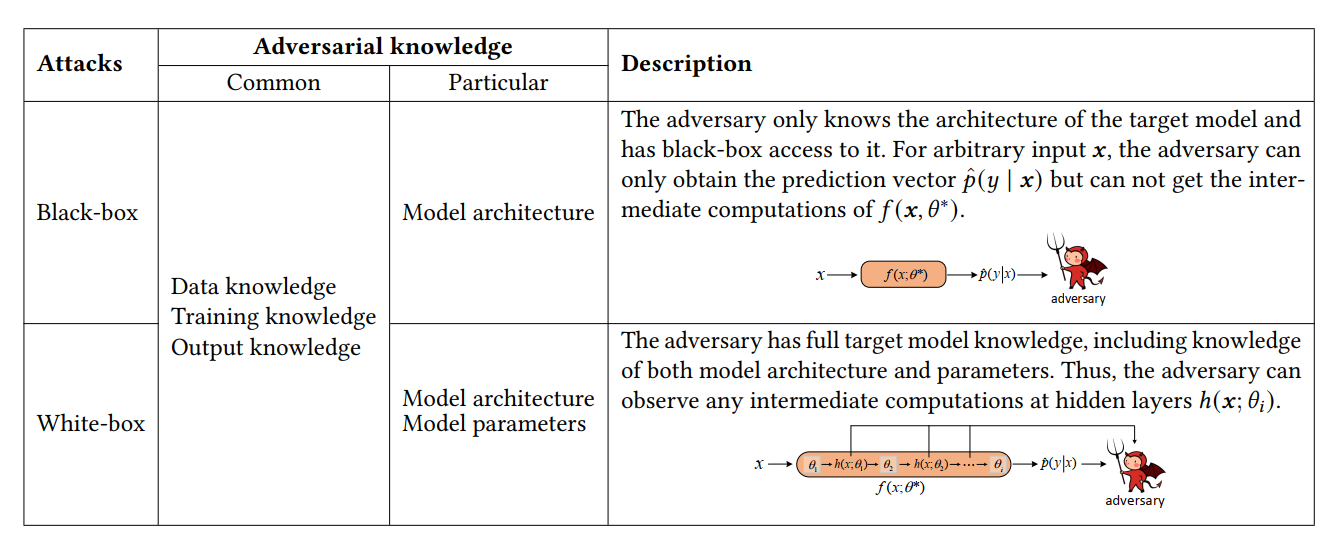


## Membership Inference Attack (MIA) Methods

### If our ML method behaves differently on test and train datasets, this model is vulnerable to MIA. This means the ML methods that overfit on the train data are more vulnerable to MIA.

### There are two types of MIA attacks:
   * Neural network based attacks
   * Metric based attacks

### Neural network based attacks

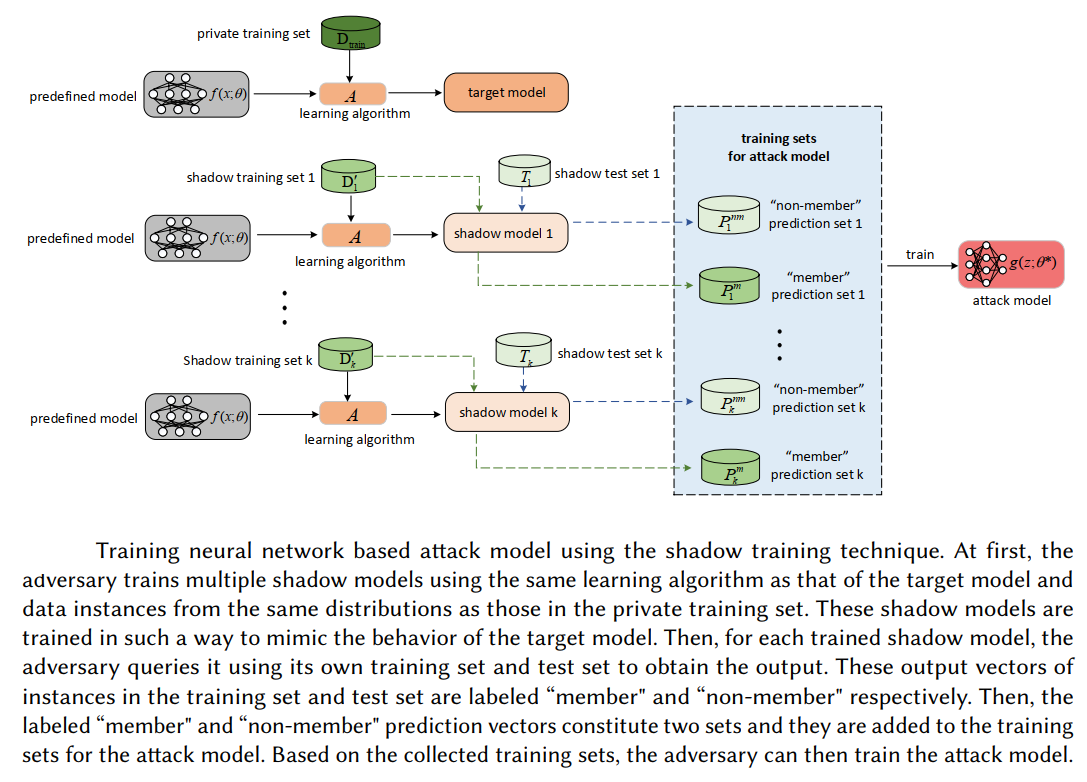

### Metric based attacks
* Prediction correctness based attack
* Prediction loss based attack
* Prediction confidence based attack
* Prediction entropy based attack

## Defences Against Membership Inference Attacks
* Confidence score masking
* Regularization
* Differential privacy

# A simple example on doing Membership Inference Attacks with TensorFlow Privacy

### Importing Required Packages:

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy import special

# tensorflow imports
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

2021-11-01 09:03:44.608870: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-01 09:03:44.608905: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# install the most recent verson of tensorflow-privacy
# !pip install -U git+https://github.com/tensorflow/privacy


In [4]:
# tensorflow-privacy 
from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack

In the above cell, the first line imports the membership inference attack itself. 
The next three lines import data structures required for the attack. In the follownig, We will provide explanations on each separately.

<br>

`AttackInputData:` is used to specify what information *f*<sub>*attack*</sub>
 will receive. The *f*<sub>*attack*</sub>  is the binary classifier trained to predict, whether this data point was part of the training data or not. The input for the training the *f*<sub>*attack*</sub> are outputs (or other whitebox-like information) of a trained shadow models and the binary target is based on the dact that data has beeb used for training the associated shadow model.
 
You can specify the followings as `AttackInputData`:

* `train and test logits` or `train and test probabilities`
* `train and test loss`
* `train and test labels` (as integer arrays)

Either labels, logits, or losses should be set to be able to perform the attack. As we will see these attributes can be obtained from our trained model.


<br>

`SlicingSpec`: This one provide us with the possibility of slicing our dataset. In fact, by the help of this, we can determine the success of the membership inference attack over specific data groups or classes. According to the code you have the following options that can be set to True:

* entire_dataset: one of the slices will be the entire dataset
* by_class: one slice per class is generated
* by_percentiles: generates 10 slices for percentiles of the loss - 0-10% 10-20%, ‚Ä¶ 90-100%
* by_classification_correctness: creates one slice for correctly classified data points, and one for misclassified data points. 


<br>

`AttackType`: gives us different options on how our membership inference attack should be conducted.

* LOGISTIC_REGRESSION = ‚Äòlr‚Äô
* MULTI_LAYERED_PERCEPTRON = ‚Äòmlp‚Äô
* RANDOM_FOREST = ‚Äòrf‚Äô
* K_NEAREST_NEIGHBORS = ‚Äòknn‚Äô
* THRESHOLD_ATTACK = ‚Äòthreshold‚Äô
* THRESHOLD_ENTROPY_ATTACK = ‚Äòthreshold-entropy‚Äô

The four first options require training a shadow model, the two last options don‚Äôt.

###  Helper functions for loading cifar10 dataset and creating a simple CCN image classification mode.

In [5]:
def load_cifar10():
  """Loads MNIST-Dataset and preprocesses to combine training and test data."""
  
  # load the existing CIFAR10 dataset that comes in form of traing + test data and labels
  train, test = tf.keras.datasets.cifar10.load_data()
  train_data, train_labels = train
  test_data, test_labels = test

  # scale the images from color values 0-255 to numbers from 0-1 to help the training process
  train_data = np.array(train_data, dtype=np.float32) / 255
  test_data = np.array(test_data, dtype=np.float32) / 255


  train_labels = np.array(train_labels, dtype=np.float32) 
  test_labels = np.array(test_labels, dtype=np.float32) 


  # cifar10 labels come one-hot encoded, there
  train_labels = train_labels.flatten()
  test_labels = test_labels.flatten()

  return train_data, train_labels, test_data, test_labels
 
def make_simple_model():
  """ Define a Keras model without much of regularization
  Such a model is prone to overfitting"""
  shape = (32, 32, 3)
  input = Input(shape=shape)
  x = Conv2D(32, (3, 3), activation='relu')(input)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  # if we don't specify an activation for the last layer, we can have the logits
  x = Dense(10)(x)
  model = Model(input, x)
  return model

### Loading the dataset

In [6]:

train_data, train_labels, test_data, test_labels = load_cifar10()

170508288/170498071 [==============================] - 2s 0us/step


### Visualizing some of the training images

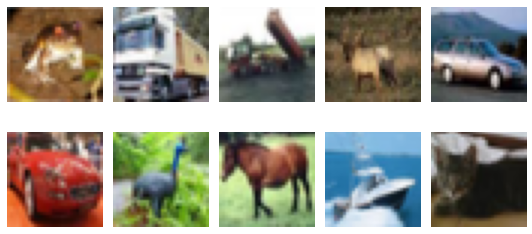

In [7]:
# show some train data
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.set_axis_off()
    ax.imshow(train_data[i])

plt.tight_layout()
plt.show()

In [8]:
train_data.shape

(50000, 32, 32, 3)

### Creating the CNN model

In [9]:
# make the neural network model with the function specified above.
# one model is supposed to train for 10, one for 50 epochs
model = make_simple_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928 

2021-11-01 09:05:05.770612: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-01 09:05:05.770735: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-01 09:05:05.770802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-11-01 09:05:05.770868: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2021-11-01 09:05:05.770943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

### Specifing the parameters and compiling the model

In [10]:
# specify parameters
learning_rate=.001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Model Training
Train the model for 30 epochs. 

After trainig the model, we use the TensorFlow Privacy Library on the trained models in order to quantify the membership inference risk. 


In [12]:
# train the model
epochs=30
history = model.fit(train_data, train_labels,
                       validation_data=(test_data, test_labels),
                       batch_size=128, 
                       epochs=epochs)

391/391 [==============================] - 48s 124ms/step - loss: 1.1838 - accuracy: 0.5832 - val_loss: 1.1389 - val_accuracy: 0.5938


(0.0, 1.0)

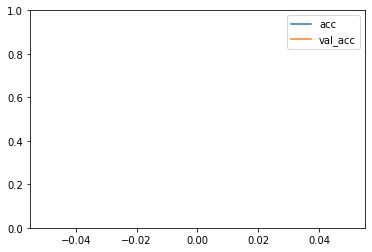

In [13]:
# plot accuracy for the first model
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend();
plt.ylim(0,1)

### Attack on the model:

Before conducting the attack, we need to calculate the inputs that attacker needs. Here we calculate the output logits, output probabilities, and losses for train and test splits.

In [14]:
# since we have not specified an activation function on the last layer
# calling the predict function returns the logits
print('Predict on train...')
logits_train = model.predict(train_data)
print('Predict on test...')
logits_test = model.predict(test_data)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

y_train_onehot = to_categorical(train_labels)
y_test_onehot = to_categorical(test_labels)

loss_train = cce(constant(y_train_onehot), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(y_test_onehot), constant(prob_test), from_logits=False).numpy()

Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...


### Define what variables our attacker should have access to

After calculating the necessary input for creating our attackers, using the `AttackInputData` we define variables that our attacker have access to

In [15]:
# define what variables our attacker should have access to
attack_input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = train_labels.astype(np.int8),
  labels_test = test_labels.astype(np.int8)
)

### Specifying the data partitions that we would like run attacks on them.
Data partitions are defined using the `SlicingSpec`

In [16]:
# how should the data be sliced
slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)

### Defining type of attackers that we use. 

Here I am choosing the THRESHOLD_ATTACK and LOGISTIC_REGRESSION as my attack types.

In [17]:
# define the type of attacker model that we want to use
attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION
]

### Running the attack
After creating the attack_input, slicing_spec, and attack_types we can run the defined attacks as follows

In [18]:
# run the attack
attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)

The `attack_result` object can provide us with some thorough insight into the attack. We can, for example, use the following code to see the attack results specified per-slice, as we have requested attacks by class and by model's classification correctness.

In [19]:
# summary by data slice (the best performing attacks per slice are presented)
print(attacks_result.summary(by_slices=True))

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.55 on slice CLASS=5
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage of 0.14 on slice CLASS=5

Best-performing attacks over slice: "Entire dataset"
  THRESHOLD_ATTACK (with 50000 training and 10000 test examples) achieved an AUC of 0.51
  THRESHOLD_ATTACK (with 50000 training and 10000 test examples) achieved an advantage of 0.02

Best-performing attacks over slice: "CLASS=0"
  THRESHOLD_ATTACK (with 5000 training and 1000 test examples) achieved an AUC of 0.51
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage of 0.08

Best-performing attacks over slice: "CLASS=1"
  THRESHOLD_ATTACK (with 5000 training and 1000 test examples) achieved an AUC of 0.51
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage of 0.07

Best-performing attacks over slice: "CLAS

### In addition to a written summary, you can also plot the ROC curve of the most successful attack

Figure(432x288)


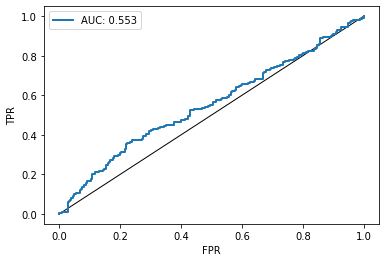

In [20]:
# plot the curve, we see that the attacker is much better than random guessing
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
print(plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve))

### Defending the Membership Inference Attacks Using Differential Privacy in Tensorflow Privacy

Here we replace the Adam optimizer with its differentially private counterpart to how differential privacy can improve robustness against the MIA.

All the above steps will be taken again. The only change is replacing Adam with its differentially private counterpart.

In [21]:
# make the neural network model with the function specified above.
# one model is supposed to train for 10, one for 50 epochs
model = make_simple_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          3692

In [22]:
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasAdamOptimizer

In [23]:
# specify parameters


noise_multiplier=.01
l2_norm_clip=1
num_microbatches=1
learning_rate=.001

#optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
optimizer = DPKerasAdamOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,num_microbatches=num_microbatches, learning_rate=learning_rate)


# Options for DP SGD:
# optimizer = DPKerasSGDOptimizer(
#             l2_norm_clip=l2_norm_clip,
#             noise_multiplier=noise_multiplier,
#             num_microbatches=num_microbatches,
#             learning_rate=learning_rate)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [24]:
# train the model
epochs=30
history = model.fit(train_data, train_labels,
                       validation_data=(test_data, test_labels),
                       batch_size=128, 
                       epochs=epochs)

391/391 [==============================] - 52s 128ms/step - loss: 2.0406 - accuracy: 0.2513 - val_loss: 1.8534 - val_accuracy: 0.3198


(0.0, 1.0)

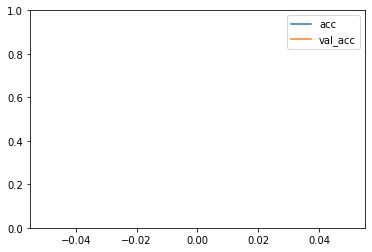

In [25]:
# plot accuracy for the first model
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend();
plt.ylim(0,1)

In [26]:
# since we have not specified an activation function on the last layer
# calling the predict function returns the logits
print('Predict on train...')
logits_train = model.predict(train_data)
print('Predict on test...')
logits_test = model.predict(test_data)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

y_train_onehot = to_categorical(train_labels)
y_test_onehot = to_categorical(test_labels)

loss_train = cce(constant(y_train_onehot), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(y_test_onehot), constant(prob_test), from_logits=False).numpy()

Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...


In [27]:
# define what variables our attacker should have access to
attack_input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = train_labels.astype(np.int8),
  labels_test = test_labels.astype(np.int8)
)

In [28]:
# how should the data be sliced
slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)

In [29]:
# define the type of attacker model that we want to use
attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION
]

In [30]:
# run the attack
attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)

In [31]:
# summary by data slice (the best performing attacks per slice are presented)
print(attacks_result.summary(by_slices=True))

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.55 on slice CLASS=8
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage of 0.10 on slice CLASS=8

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 10000 training and 10000 test examples) achieved an AUC of 0.50
  LOGISTIC_REGRESSION (with 10000 training and 10000 test examples) achieved an advantage of 0.02

Best-performing attacks over slice: "CLASS=0"
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.48
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage of 0.06

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.53
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage of 0.09

Best-performing attacks over 

Figure(432x288)


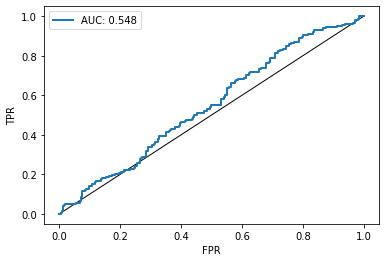

In [32]:
# plot the curve, we see that the attacker is much better than random guessing
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
print(plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve))

# References

* A survey on MIA for machine lerarning algorithms in [this](https://arxiv.org/abs/2103.07853) paper.

* Tensorflow privacy [Github page](https://github.com/tensorflow/privacy/tree/master/tensorflow_privacy/privacy/privacy_tests/membership_inference_attack).

* Blog posts from Franziska Boenisch on Attacks against Machine Learning Privacy [part 1](https://franziska-boenisch.de/posts/2020/12/model-inversion/) and [part 2](https://franziska-boenisch.de/posts/2021/01/membership-inference/).